In [1]:
import matplotlib.pyplot as plt
plt.style.use("../styles/hda.mplstyle")

(chp-map-making)=
# Narrating with Maps

(sec-map-making-introduction)=
## Introduction

This chapter discusses some fundamental techniques for drawing <span class="index">geographical map</span>s in
Python. Scholars in the humanities and social sciences have long recognized the value
of maps as a familiar and expressive medium for interpreting, explaining, and communicating
scholarly work. When the objects we analyze are linked to events taking place on or near
the surface of the Earth, these objects can frequently be associated with real
coordinates, i.e., latitude and longitude pairs. When such pairs are available, a common
task is to assess whether or not there are interesting spatial patterns among them. Often
the latitude and longitude pairs are augmented by a time stamp of some kind indicating the
date or time an event took place. When such time stamps are available, events can often be
visualized on a map in sequence. This chapter outlines the basic steps required to display
events on a map in such a narrative.

```{margin}
The existence of such freely available and carefully curated data is
itself worth mentioning. Wars, in particular those tied to national identity, tend to
be well-documented. In the case of the United States, military conflict continues to
distinguish the country from other developed economies. The country invaded two
countries in the 2000s and has ongoing military operations in several countries. The
United States government spends more money on its military than any other country in
the world.
```
As our object of scrutiny, we will explore a dataset documenting 384 significant battles
of the American <span class="index">Civil War</span> (1861--1865), which was collected by the United States government,
specifically the Civil War Sites Advisory Commission (CWSAC), part of the American Battlefield
Protection Program. In addition to introducing some of the most
important concepts in plotting data on geographical maps, the goal of this chapter is to
employ narrative mapping techniques to obtain an understanding of some important
historical events and developments of the Civil War. In particular, we will concentrate on
the *trajectory* of the war, and show how the balance of power between the war's two main
antagonists---the Union Army and the Confederate States Army---changed both
geographically and diachronically.

The remainder of this brief chapter is structured as follows: Like any other data
analysis, we will begin with loading, cleaning, and exploring our data in section
{ref}`sec-map-making-data`. Subsequently, we will demonstrate how to draw simple
geographical maps using the package "<span class="index">Cartopy</span>", which is Python's (emerging) standard for
geospatial data processing and analysis
(section {ref}`sec-map-making-projections-and-basemaps`. In the pre-final section ({ref}`sec-map-making-time-series-maps`), then, we will use these
preliminary steps and techniques to map out the development of the Civil War. Some
suggestions for additional reading materials are given in the final section.

(sec-map-making-data)=
## Data Preparations

The data used here have been gathered from the [Civil War Sites Advisory
Commission](https://web.archive.org/web/20170430064531/https://www.nps.gov/abpp/battles/bystate.htm)
website.
{numref}`fig-map-making-summary-cold-harbor` below shows a screenshot of the page for the
[Battle of Cold Harbor](https://en.wikipedia.org/wiki/Battle_of_Cold_Harbor), a battle
which involved 170,000 people. The data from the Civil War Sites Advisory Commission were
further organized into a [csv
file](http://acw-battle-data.readthedocs.io/en/latest/resources/cwsac_battles.html) by
{cite:t}`arnold2018american`. We will begin by looking up the Battle of
Cold Harbor in the table assembled by Arnold:

```{figure} figures/cwsac-cold-harbor-screenshot.png
---
name: fig-map-making-summary-cold-harbor
width: 50%
---

CWSAC summary of the Battle of Cold Harbor. Source: National Park Service, <https://web.archive.org/web/20170509065005/https://www.nps.gov/abpp/battles/va062.htm>
```

In [2]:
import pandas as pd

df = pd.read_csv('data/cwsac_battles.csv', parse_dates=['start_date'], index_col=0)
df.loc[df['battle_name'].str.contains('Cold Harbor')].T

battle                                                       VA062
url                      http://www.nps.gov/abpp/battles/va062.htm
battle_name                                            Cold Harbor
other_names                                     Second Cold Harbor
state                                                           VA
locations                                       Hanover County, VA
campaign                 Grant's Overland Campaign [May-June 1864]
start_date                                     1864-05-31 00:00:00
end_date                                                1864-06-12
operation                                                        0
assoc_battles                                                  NaN
results_text                                   Confederate victory
result                                                 Confederate
forces_text                  170,000 total (US 108,000; CS 62,000)
strength                                                  170000.0
casualties_text                 15,500 total (US 13,000; CS 2,500)
casualties                                                 15500.0
description      On May 31, Sheridan's cavalry seized the vital...
preservation                                                   I.1
significance                                                     A
strength_mean                                             170000.0
strength_var                                         166666.666667

For each battle, the dataset provides a date (we will use the column ``start_date``) and
at least one location. For the "Battle of Cold Harbor", for example, the location provided
is "Hanover County, VA". The locations in the dataset are as precise as English-language
descriptions of places ever get. All too often datasets include location names such as
"Lexington" which do not pick out one location---or even a small number of locations --
in North America. Because the location names used here are precise, it is easy to find an
appropriate latitude and longitude pair---or even a sequence of <span class="index">latitude</span> and <span class="index">longitude</span>
pairs describing a bounding <span class="index">polygon</span>---for the named place. It is possible, for example,
to associate "Hanover County, VA" with a polygon describing the [administrative region by
that name](https://en.wikipedia.org/wiki/Hanover_County,_Virginia). The center of this
particular polygon is located at 37.7 latitude, -77.4 longitude.

There are several online services which, given the name of a location such as "Hanover
County, VA", will provide the latitude and longitude associated with the name. These
services are known as "<span class="index">geocoding</span>" services. The procedures for accessing these services
vary. 
```{margin}
The file ``fetch_battle_lat_lon.py`` accompanying this book contains
the code used to perform this task for the current dataset.
```
One of these services has been used to geocode all the place names in the
``location`` column. The mapping that results from
this geocoding has a natural expression as a Python dictionary. The following block of
code loads this dictionary from its serialized form and adds the latitude and longitude pair
of location of each battle to the battles table `df`.

In [3]:
import pickle
import operator


with open('data/cwsac_battles_locations.pkl', 'rb') as f:
    locations = pickle.load(f)

# first, exclude 2 battles (of 384) not associated with named locations
df = df.loc[df['locations'].notnull()]

# second, extract the first place name associated with the battle.
# (Battles which took place over several days were often associated
# with multiple (nearby) locations.)
df['location_name'] = df['locations'].str.split(';').apply(operator.itemgetter(0))

# finally, add latitude (`lat`) and longitude ('lon') to each row
df['lat'] = df['location_name'].apply(lambda name: locations[name]['lat'])
df['lon'] = df['location_name'].apply(lambda name: locations[name]['lon'])

After associating each battle with a location, we can inspect our work by displaying a few
of the more well-known battles of the war. Since many of the best-known battles were also
the bloodiest, we can display the top three battles ranked by recorded casualties:

In [4]:
columns_of_interest = [
    'battle_name', 'locations', 'start_date', 'casualties', 'lat', 'lon', 'result',
    'campaign'
]
df[columns_of_interest].sort_values('casualties', ascending=False).head(3)

battle_name                              locations  \
battle                                                                    
PA002                 Gettysburg                       Adams County, PA   
GA004                Chickamauga  Catoosa County, GA; Walker County, GA   
VA048   Spotsylvania Court House                Spotsylvania County, VA   

       start_date  casualties        lat        lon        result  \
battle                                                              
PA002  1863-07-01     51000.0  39.873030 -77.217873         Union   
GA004  1863-09-18     34624.0  34.904493 -85.135566   Confederate   
VA048  1864-05-08     30000.0  38.184116 -77.655980  Inconclusive   

                                            campaign  
battle                                                
PA002           Gettysburg Campaign [June-July 1863]  
GA004   Chickamauga Campaign [August-September 1863]  
VA048      Grant's Overland Campaign [May-June 1864]

Everything looks right. The battles at Gettysburg and at the Spotsylvania Courthouse lie
on approximately the same line of longitude, which is what we should expect. Now we can
turn to plotting battles such as these on a map of the United States.

(sec-map-making-projections-and-basemaps)=
## Projections and Basemaps

```{margin}
The most widely used projection is [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator). It should be stressed, however, that this projection is also widely disdained by geographers because it assumes the Earth is a sphere rather than ellipsoid.
```
Before we can visually identify a location in the present-day United States, we first need a two-dimensional map. Because the American Civil War, like every other war, did not take place on a two-dimensional surface but rather on the surface of a spherical planet, we need to first settle on a procedure for representing a patch of a sphere in two dimensions. There are countless ways to contort a patch of a sphere into two dimensions.
Once the three-dimensional surface of interest has been "flattened" into two dimensions,
we will need to pick a particular rectangle within it for our map. This procedure
invariably involves selecting a few more parameters than one might expect on the basis of
experience working with two-dimensional visualizations. For instance, in addition to the
two points needed to specify a rectangle in two dimensions, we need to fix several
projection-specific parameters. Fortunately, there are reasonable default choices for
these parameters when one is interested in a familiar geographical area such as the land
mass associated with the continental United States. The widely used <span class="index">projection</span> we adopt here is called the "[<span class="index">Lambert Conformal Conic Projection</span>](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection)" (LCC).

Once we have a projection and a bounding rectangle, we will need first to draw the land
mass we are interested in, along with any political boundaries of interest. As both land
masses and political boundaries tend to change over time, there are a wide range of data to
choose from. These data come in a variety of formats. A widely used format is the "<span
class="index">shapefile</span>" format. Data using the shapefile format may be recognized
by the extensions the files use. A 'shapefile' consists of at least three separate files
where the files make use of the following extensions: ``.shp`` (feature geometry),
``.shx`` (an index of features), and ``.dbf`` (attributes of each shape). Those familiar
with relational databases will perhaps get the general idea: a database consisting of
three tables linked together with a common index. We will use a shapefile provided by the
US government which happens to be distributed with the Matplotlib library. The block of
code below will create a "basemap", which shows the area of the United States of interest
to us.

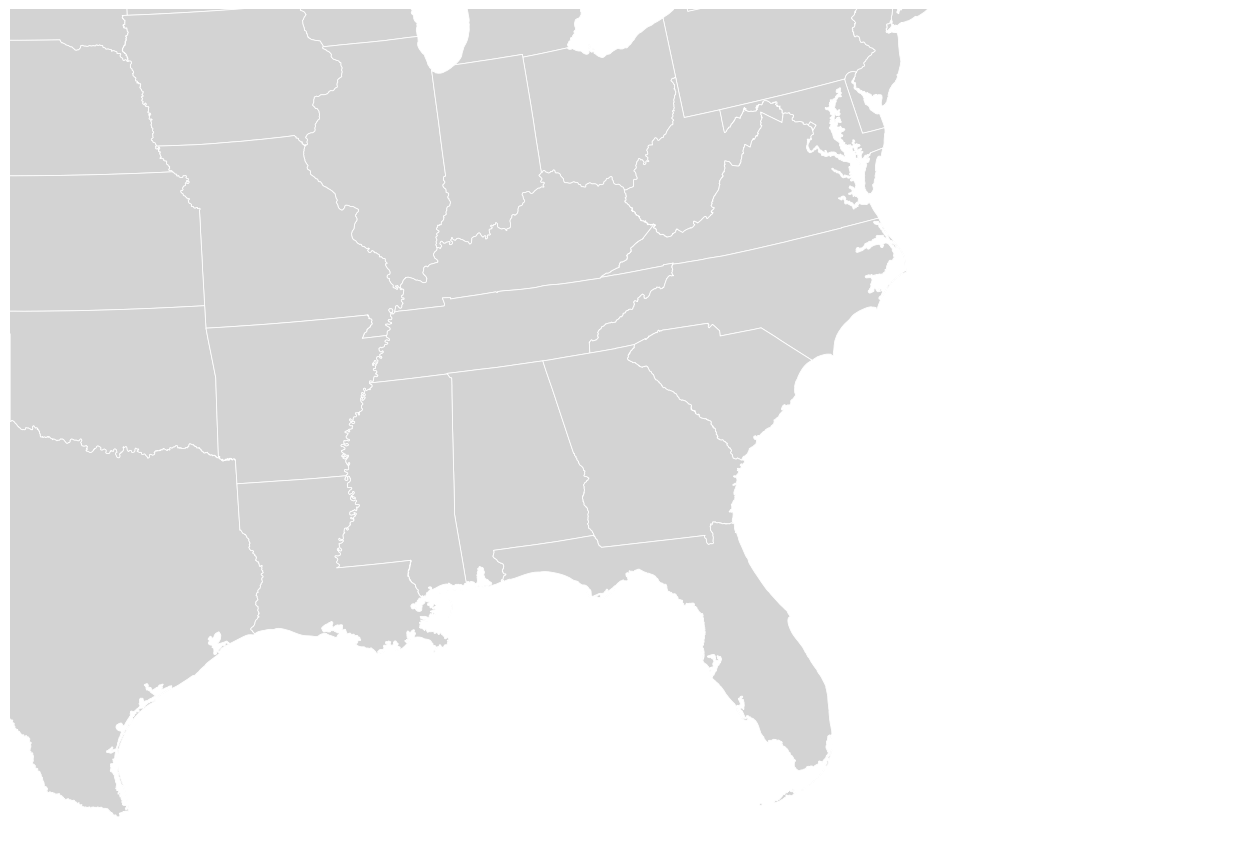

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
from cartopy.feature import ShapelyFeature

# Step 1: Define the desired projection with appropriate parameters
# Lambert Conformal Conic (LCC) is a recommended default projection.
# We use the parameters recommended for the United States described
# at http://www.georeference.org/doc/lambert_conformal_conic.htm :
# 1. Center of lower 48 states is roughly 38°, -100°
# 2. 32° for first standard latitude and 44° for the second latitude

projection = ccrs.LambertConformal(
    central_latitude=38, central_longitude=-100,
    standard_parallels=(32, 44))

# Step 2: Set up a base figure and attach a subfigure with the
# defined projection
fig = plt.figure(figsize=(8, 8))
m = fig.add_subplot(1, 1, 1, projection=projection)
# Limit the displayed to a bounding rectangle
m.set_extent([-70, -100, 40, 25], crs=ccrs.PlateCarree())

# Step 3: Read the shapefile and transform it into a ShapelyFeature
shape_feature = ShapelyFeature(
    shapereader.Reader('data/st99_d00.shp').geometries(),
    ccrs.PlateCarree(), facecolor='lightgray', edgecolor='white')
m.add_feature(shape_feature, linewidth=0.3)

# Step 4: Add some aesthetics (i.e. no outline box)
m.spines['geo'].set_visible(False)

<!-- Figure: Geographical map showing the area in which the US Civil War took place.\label{fig:map-making-basemap} -->

Settling on a basemap is the most difficult part of making a map. Now that we have a
basemap, plotting locations as points and associating text labels with points has the same
form as it does when visualizing numeric data on the XY axis. Before we continue, let us
first implement a procedure wrapping the map creating into a more convenient function. The
function <span class="index">``civil_war_basemap()``</span> defined below enables us to display single or multiple
basemaps on a grid, which will prove useful in our subsequent map narratives.

In [6]:
def basemap(shapefile, projection, extent=None, nrows=1, ncols=1, figsize=(8, 8)):
    f, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=100,
        subplot_kw=dict(projection=projection, frameon=False))
    axes = [axes] if (nrows + ncols) == 2 else axes.flatten()
    shape_feature = ShapelyFeature(
            shapereader.Reader(shapefile).geometries(),
            ccrs.PlateCarree(), facecolor='lightgray', edgecolor='white')
    for ax in axes:
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(shape_feature, linewidth=0.3)
        ax.spines['geo'].set_visible(False)
    return f, (axes[0] if (nrows + ncols) == 2 else axes)

def civil_war_basemap(nrows=1, ncols=1, figsize=(8, 8)):
    projection = ccrs.LambertConformal(
        central_latitude=38, central_longitude=-100,
        standard_parallels=(32, 44))
    extent = -70, -100, 40, 25
    return basemap('data/st99_d00.shp', projection, extent=extent,
                   nrows=nrows, ncols=ncols, figsize=figsize)

(sec-map-making-plotting-battles)=
## Plotting Battles

The next map we will create displays the location of three battles: (i) 
Baton Rouge, (ii) Munfordville, and (iii) Second Manassas. The <span class="index">latitude</span> and <span class="index">longitude</span> of these
locations have been added to the battle dataframe `df` in a previous step. In order to
plot the battles on our basemap we need to convert the latitude and longitude pairs into
map <span class="index">projection</span> coordinates (recorded in meters). The following blocks of code illustrate
converting between the universal coordinates---well, at least planetary---of latitude
and longitude and the map-specific XY-coordinates.

In [7]:
# Richmond, Virginia has decimal latitude and longitude:
#    37.533333, -77.466667
x, y = m.transData.transform((37.533333, -77.466667))
print(x, y)

200.01533942069264 958.8639317948623


In [8]:
# Recover the latitude and longitude for Richmond, Virginia
print(m.transData.inverted().transform((x, y)))

[ 37.533333 -77.466667]


The three battles of interest are designated by the identifiers "LA003", "KY008",
"VA026". For convenience, we construct a new data frame consisting of these three battles:

In [9]:
battles_of_interest = ['LA003', 'KY008', 'VA026']
three_battles = df.loc[battles_of_interest]

In addition to adding three points to the map, we will annotate the points with labels
indicating the battle names. The following block of code constructs the labels we will
use:

In [10]:
battle_names = three_battles['battle_name']
battle_years = three_battles['start_date'].dt.year
labels = [f'{name} ({year})' for name, year in zip(battle_names, battle_years)]
print(labels)

['Baton Rouge (1862)', 'Munfordville (1862)', 'Manassas, Second (1862)']


Note that we make use of the property ``year`` associated with the column
``start_date``. This property is accessed using the ``dt`` attribute. The ``str``
attribute "namespace" for text columns is another important case where Pandas uses this
particular convention (cf. chapter {ref}`chp-working-with-data`).

In the next block of code, we employ these labels to annotate the locations of the
selected battles (see figure {ref}`fig-map-making-battle-plot`). First, using the keyword
argument `transform` of Matplotlib's `scatter()` function, we can plot them in much the same
way as we would plot any values using Matplotlib. Next, the function which adds the
annotation (a text label) to the plot has a number of parameters. The first three
parameters are easy to understand: (i) the text of the label, (ii) the coordinates of the
point being annotated, and (iii) the coordinates of the text label. Specifying the
coordinates of the text labels directly in our case is difficult, because the units of the
coordinates are in meters. Alternatively, we can indicate the distance ("offset") from the
chosen point using a different coordinate system. In this case, we use units of "points",
familiar from graphic design, by using `'offset points'` as the ``textcoords``
parameter. (A point is 0.353 mm or 1/72 of an inch.)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


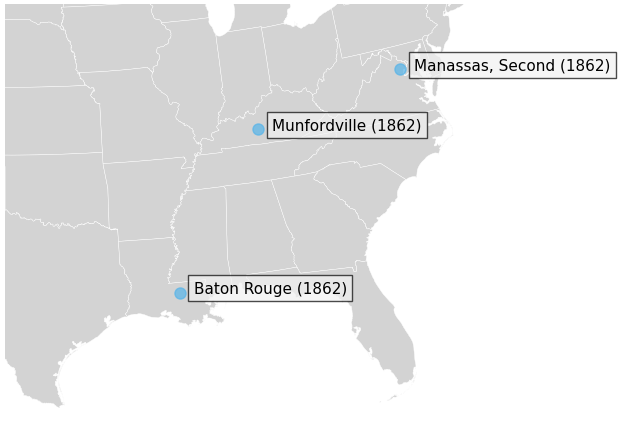

In [11]:
# draw the map
f, m = civil_war_basemap(figsize=(8, 8))
# add points
m.scatter(three_battles['lon'], three_battles['lat'],
          zorder=2, marker='o', alpha=0.7, transform=ccrs.PlateCarree())
# add labels
for x, y, label in zip(three_battles['lon'], three_battles['lat'], labels):
    # NOTE: the "plt.annotate call" does not have a "transform=" keyword,
    # so for this one we transform the coordinates with a Cartopy call.
    x, y = m.projection.transform_point(x, y, src_crs=ccrs.PlateCarree())
    # position each label to the right of the point
    # give the label a semi-transparent background so it is easier to see
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 0),
                 # xytext is measured in figure points,
                 # 0.353 mm or 1/72 of an inch
                 textcoords='offset points',
                 bbox=dict(fc='#f2f2f2', alpha=0.7))

<!-- Figure: Geographical map showing the location of the battles of Baton Rouge, Munfordville, and Second Manassas.\label{fig-map-making-battle-plot} -->

This map, while certainly intelligible, does not show us much besides the location of
three battles---which are not immediately related. As a narrative, then, the map leaves
much to be desired. Since our data associate each battle with starting dates and casualty
counts, we have the opportunity to narrate the development of the war through these
data. In the next section we introduce the idea of displaying both these data (date and
number of casualties) through a *series* of maps.

(sec-map-making-time-series-maps)=
## Mapping the Development of the War

The number of Union Army and Confederate States Army casualties associated with each
battle is the easiest piece of information to add to the map. The size of a circle drawn
at the location of each battle can communicate information about the number of
casualties. Inspecting the casualties associated with the three battles shown in the
figure above, we can see that the number of casualties differs considerably:

In [12]:
three_battles[columns_of_interest]

battle_name                    locations start_date  casualties  \
battle                                                                         
LA003        Baton Rouge  East Baton Rouge Parish, LA 1862-08-05       849.0   
KY008       Munfordville              Hart County, KY 1862-09-14      4862.0   
VA026   Manassas, Second    Prince William County, VA 1862-08-28     22180.0   

              lat        lon       result  \
battle                                      
LA003   30.542141 -91.095604        Union   
KY008   37.294492 -85.884709  Confederate   
VA026   38.662376 -77.432476  Confederate   

                                                 campaign  
battle                                                     
LA003   Operations Against Baton Rouge [July-August 1862]  
KY008   Confederate Heartland Offensive [June-October ...  
VA026            Northern Virginia Campaign [August 1862]

Drawing a circle with its area proportional to the casualties achieves the goal of
communicating information about the human toll of each battle. The absolute size of the
circle carries no meaning in this setting but the relative size does. For example, the
Battle of Munfordville involved 5.7 times the casualties of the Battle of Baton Rouge, so
the area of the circle is 5.7 times larger. When making a <span class="index">scatter plot</span> with Matplotlib,
whether we are working with a map or a conventional two-dimensional plot, we specify the
size of the marker with the parameter ``s``. The function below wraps up the relevant
steps into a single function. To avoid obscuring the political boundaries visible on the
map, we make our colored circles transparent using the ``alpha`` parameter. Since the
dataset includes an indicator of the military "result" of the battle (either
"Confederate", "Inconclusive", "Union"), we will also use different color circles
depending on the value of the ``result`` variable. Battles associated with a Confederate
victory will be colored blue, those which are labeled "Inconclusive" will be colored
orange, and Union victories will be colored green. The map is shown in figure
{ref}`fig-map-making-battle-plot-casualties`.

In [13]:
import itertools
import matplotlib.cm


def result_color(result_type):
    """Helper function: return a qualitative color for each
       party in the war.
    """
    result_types = 'Confederate', 'Inconclusive', 'Union'
    # qualitative color map, suited for categorical data
    color_map = matplotlib.cm.tab10
    return color_map(result_types.index(result_type))


def plot_battles(lat, lon, casualties, results, m=None, figsize=(8, 8)):
    """Draw circles with area proportional to `casualties`
       at `lat`, `lon`.
    """
    if m is None:
        f, m = civil_war_basemap(figsize=figsize)
    else:
        f, m = m
    # make a circle proportional to the casualties
    # divide by a constant, otherwise circles will cover much of the map
    size = casualties / 50
    for result_type, result_group in itertools.groupby(
        zip(lat, lon, size, results), key=operator.itemgetter(3)):
        lat, lon, size, results = zip(*list(result_group))
        color = result_color(result_type)
        m.scatter(lon, lat, s=size, color=color, alpha=0.8,
                  label=result_type, transform=ccrs.PlateCarree(), zorder=2)
    return f, m

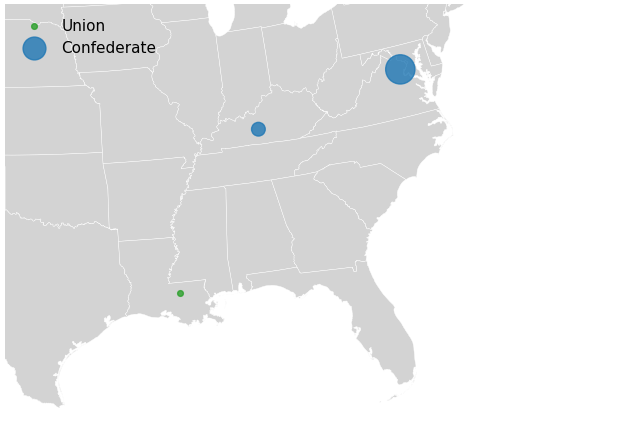

In [14]:
lat, lon, casualties, results = (three_battles['lat'], three_battles['lon'],
                                 three_battles['casualties'], three_battles['result'])
plot_battles(lat, lon, casualties, results)
plt.legend(loc='upper left');

<!-- Figure: Geographical map showing the location of the battles of Baton Rouge, Munfordville, and Second Manassas. Colors indicate the military "result", and the size of the nodes represents the number of casualties.\label{fig-map-making-battle-plot-casualties} -->

In order to plot all battles on a map (that is, not just these three), we need to make
sure that each battle is associated with a casualties figure. We can accomplish this by
inspecting the entire table and identifying any rows where the ``casualties`` variable is
associated with a NaN (not a number) value. The easiest method for selecting such rows is
to use the <span class="index">``Series.isnull()``</span> method (cf. chapter {ref}`chp-working-with-data`). Using
this method, we can see if there are any battles without casualty figures. There are in
fact 65 such battles, three of which are shown below:

In [15]:
df.loc[df['casualties'].isnull(), columns_of_interest].head(3)

battle_name             locations start_date  casualties        lat  \
battle                                                                         
AR007    Chalk Bluff       Clay County, AR 1863-05-01         NaN  36.378952   
AR010   Bayou Forche    Pulaski County, AR 1863-09-10         NaN  34.754519   
AR011     Pine Bluff  Jefferson County, AR 1863-10-25         NaN  34.268790   

              lon       result  \
battle                           
AR007  -90.417358  Confederate   
AR010  -92.251272        Union   
AR011  -91.931510        Union   

                                                 campaign  
battle                                                     
AR007   Marmaduke's Second Expedition into Missouri [A...  
AR010     Advance on Little Rock [September-October 1863]  
AR011     Advance on Little Rock [September-October 1863]

Inspecting the full record of several of the battles with unknown total casualties on the
CWSAC website reveals that these are typically battles with a small (< 100) number of
Union Army casualties. The total casualties are unknown because the Confederate States
Army casualties are unknown, *not* because no information is available about the battles.

If the number of such battles were negligible, we might be inclined to ignore them.
However, because there are many such battles (65 of 382, or 17%), an alternative approach
seems prudent. Estimating the total number of casualties from the date, place, and number
of Union Army casualties would be the best approach. A reasonable second-best approach,
one which we will adopt here, is to replace the unknown values with a plausible estimate.
Since we can observe from the text description of the battles with unknown casualty counts
that they indeed tend to be battles associated with fewer than 100 Union Army casualties,
we can replace these unknown values with a number that is a reasonable estimate of the
total number of casualties. One such estimate is 218 casualties, the number of casualties
associated with a relatively small battle such as the 20th percentile (or 0.20-quantile)
of the known casualties. (The 20th percentile of a series is the number below which 20% of
observations fall.) This is likely a modest overestimate but it is certainly preferable to
discarding these battles given that we know that the battles without known casualties did,
in fact, involve many casualties.

The following blocks of code display the 20th percentile of observed casualties, and,
subsequently replace any casualties which are ``NaN`` with that 0.20-quantile value.

In [16]:
print(df['casualties'].quantile(0.20))

218.4


In [17]:
df.loc[df['casualties'].isnull(), 'casualties'] = df['casualties'].quantile(0.20)

Now that we have casualty counts for each battle and a strategy for visualizing this
information, we can turn to the task of visualizing the temporal sequence of the Civil
War.

We know that the Civil War began in 1861 and ended in 1865. A basic sense of the
trajectory of the conflict can be gained by looking at a table which records the number of
battles during each calendar year. The year during which each battle started is not a
value in our table so we need to extract it. Fortunately, we can access the integer year
via the ``year`` property. This property is nested under the ``dt`` attribute associated
with datetime-valued columns. With the year accessible, we can assemble a table which
records the number of battles by year:

In [18]:
df.groupby(df['start_date'].dt.year).size()
# alternatively, df['start_date'].dt.year.value_counts()

start_date
1861     34
1862     93
1863     95
1864    131
1865     29
dtype: int64

Similarly, we can assemble a table which records the total casualties across all battles
by year:

In [19]:
df.groupby(df['start_date'].dt.year)['casualties'].sum()

start_date
1861     16828.6
1862    283871.6
1863    225211.8
1864    292779.8
1865     60369.2
Name: casualties, dtype: float64

The tables provide, at least, a rough chronology of the war; that the war begins in 1861
and ends in 1865 is clear.

Additional information about the trajectory of the war may be gained by appreciating how
dependent on the seasons the war was. Fewer battles were fought during the winter months
(December, January, and February in North America) than in the spring, summer, and
fall. Many factors contributed to this dependency, not least the logistical difficulty
associated with moving large numbers of soldiers, equipment, and food during the winter
months over rough terrain. By adding the month to our dataset and reassembling the tables
displaying the total casualties by month, we can appreciate this.

In [20]:
df.groupby(df.start_date.dt.strftime('%Y-%m'))['casualties'].sum().head()

start_date
1861-04       0.0
1861-05      20.0
1861-06     198.0
1861-07    5555.0
1861-08    3388.0
Name: casualties, dtype: float64

All that remains is to combine these monthly statistics with geographical information. To
this end, we will plot a monthly <span class="index">series of maps</span>, each of which displays the battles and
corresponding casualties occurring in a particular month. Consider the following code
block, which employs many ideas and functions developed in the current chapter. (Note that this code might take a while to execute, because of the high number of plots involved, as well as the high resolution at which the maps are being generated.)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


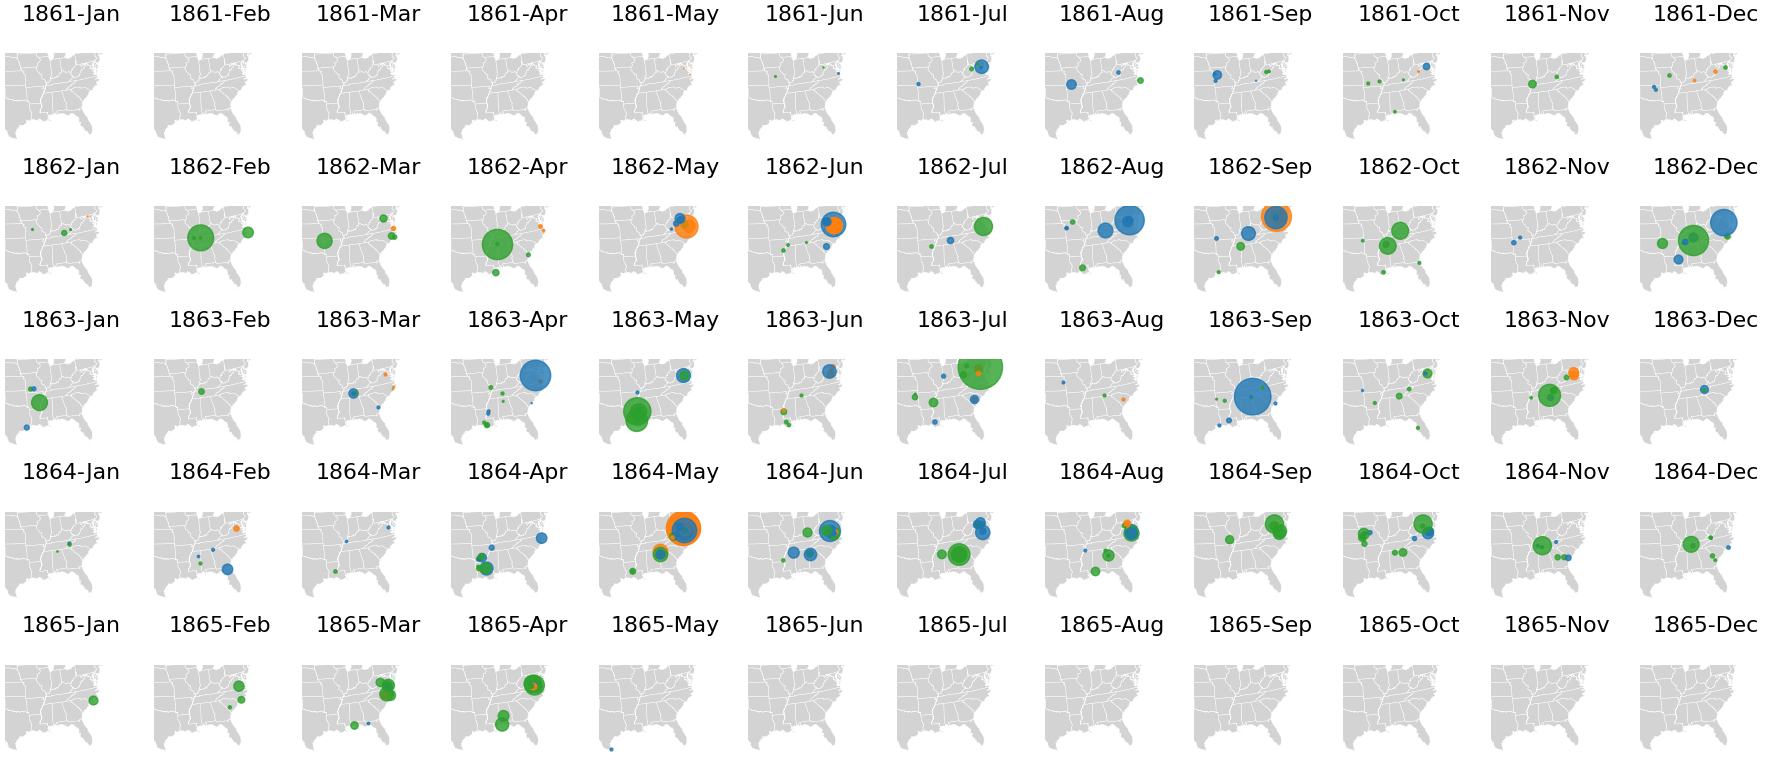

In [21]:
import calendar
import itertools

f, maps = civil_war_basemap(nrows=5, ncols=12, figsize=(18, 8))

# Predefine an iterable of dates. The war begins in April 1861, and
# the Confederate government dissolves in spring of 1865.
dates = itertools.product(range(1861, 1865 + 1), range(1, 12 + 1))

for (year, month), m in zip(dates, maps):
    battles = df.loc[(df['start_date'].dt.year == year) &
                     (df['start_date'].dt.month == month)]
    lat, lon = battles['lat'].values, battles['lon'].values
    casualties, results = battles['casualties'], battles['result']
    plot_battles(lat, lon, casualties, results, m=(f, m))
    month_abbrev = calendar.month_abbr[month]
    m.set_title(f'{year}-{month_abbrev}')

plt.tight_layout();

<!-- Figure: Series of geographical maps showing the battles and corresponding casualties occurring in a particular month during the Civil War.\label{fig-map-making-war-trajectory} -->

The series of maps is shown above. These maps make visible the trajectory of the war. The end of the war is particularly
clear: we see no major Confederate victories after the summer of 1864. While we know that
the war ended in the spring of 1865, the prevalence of Union victories (green circles)
after June 1864 make visible the extent to which the war turned against the Confederacy
well before the final days of the war. The outcome and timing of these battles matters a
great deal. Lincoln was facing re-election in 1864 and, at the beginning of the year, the
race was hotly contested due in part to a string of Confederate victories. Union victories
in and around Atlanta before the election in November 1864 are credited in Lincoln's
winning re-election by a landslide.

The series of maps shown previously offers a compact narrative of the overall
trajectory of the US Civil War. Much is missing. Too much, in fact. We have no sense of
the lives of soldiers who fought each other between 1861 and 1865. As a method of
communicating the essential data contained on the United States government's [Civil War
Sites Advisory Commission](http://acw-battle-data.readthedocs.io/en/latest/resources/cwsac_battles.html)
website, however, the maps do useful work.

## Further Reading

This brief chapter only scratched the surface of possible applications of mapping in the
humanities and social sciences. We have shown how geographical maps can be drawn using the
Python library <span class="index">Cartopy</span>. Additionally, it was demonstrated how historical data can be
visualized on top of these maps, and subsequently how such maps can help to communicate a
historical narrative. <span class="index">Historical GIS</span> (short
for "Geographic Information System") is a broad and rapidly expanding field (see, e.g.,
{cite:t}`gregory2007historical,knowles:2008`). Those interested in doing serious work with large
geospatial datasets will likely find a need for dedicated geospatial software. The
dominant open-source software for doing geospatial work is [QGIS](https://www.qgis.org/).

## Exercises
### Easy
1. The dataset includes an indicator of the military "result" of each battle (either
   "Confederate", "Inconclusive", "Union"). How many battles were won by the Confederates?
   And how many by the Union troops?
2. As mentioned in section {ref}`sec-map-making-projections-and-basemaps`, the Lambert
   Conformal Conic Projection is only one of the many available map projections. To get a
   feeling of the differences between map projections, try plotting the Civil War basemap
   with the common [Mercator
   projection](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html).
3. In our analyses, we treated all battles as equally important. However, some of them
   played a more decisive role than others. The dataset provided by {cite:t}`arnold2018american`
   categorizes each battle for significance using a [four-category classification
   system](https://acw-battle-data.readthedocs.io/en/latest/resources/cwsac_battles.html#significance). Adapt
   the code to plot the monthly series of maps to only plot battles with significance
   level "A". How does this change the overall trajectory of the US Civil War? (Hint: add
   a condition to the selection of the battles to be plotted.)

### Moderate
Evald Tang <span class="index">Kristensen</span> (1843--1929) is one of the most important collectors of Danish <span class="index">folktales</span> {cite:p}`tangherlini:2013`. In his long career, he has traveled nearly 70,000 kilometers to
record stories from more than 4,500 storytellers in more than 1,800 different
indentifiable places {cite:p}`storm:2017`. His logs provide a unique insight into how his story
collection came about, and unravels interesting aspects of the methods applied by folklore
researchers. In the following exercises, we try to unravel some his collecting methods. We
use a map of Denmark for this, which we can display with the `denmark_basemap()` function:

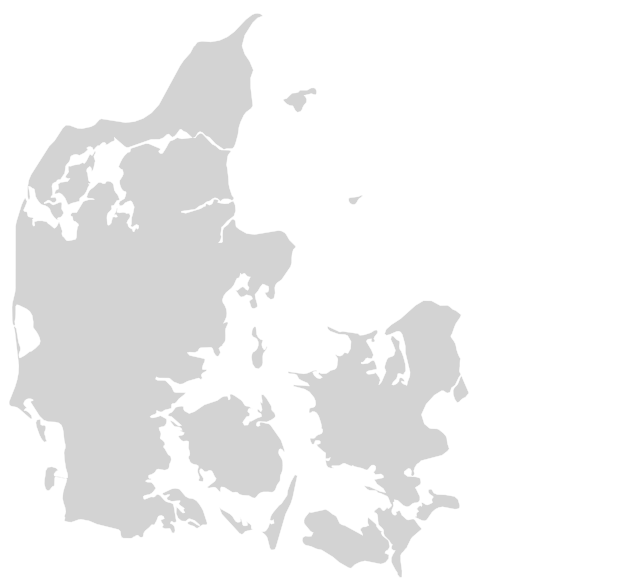

In [22]:
def denmark_basemap(nrows=1, ncols=1, figsize=(8, 8)):
    projection = ccrs.LambertConformal(central_latitude=50, central_longitude=10)
    extent = 8.09, 14.15, 54.56, 57.75
    return basemap('data/denmark/denmark.shp', projection, extent=extent,
                   nrows=nrows, ncols=ncols, figsize=figsize)

fig, m = denmark_basemap()

<!-- Figure: Geographical map of Denmark.\label{fig-map-making-denmark} -->

1. The historical GIS data of Tang Kristensen's diary pages are stored in the CSV file
   `data/kristensen.csv` (we gratefully use the data that has been made available and
   described by ({cite:t}`storm:2017`; see also {cite:t}`tangherlini:2014`). Each row in the data
   corresponds to a stop in Kristensen's travels. Load the data with Pandas and plot each
   stop on the map. The geographical coordinates of each stop are stored in the `lat`
   (latitude) and `lon` (longitude) columns of the table. (Tip: reduce the opacity of each
   stop to get a better overview of frequently visited places.)
2. Kristensen made several field trips to collect stories, which are described in the
   four volumes *Minder and Oplevelser* ("Memories and Experiences"). At each of these
   field trips, Kristensen made several stops at different places. His field trips are
   numbered in the `FT` column. Create a new map and plot the locations of the stops that
   Kristensen made on field trip 10, 50, and 100. Give each of these field trips a
   different color, and add a corresponding legend to the map.
3. The number of places that Kristensen visited during his field trips varies
   greatly. Make a plot with the trips in chronological order on the X axis and the number
   of places he visited during a particular year on the Y axis. The data has a `Year`
   column that you can use for this. What does the plot tell you about Kristensen's
   career?

### Challenging
1. To obtain further insight into the development of Kristensen's career, you will make a
   plot with a map of Denmark for each year in the collection showing all places that
   Kristensen has visited in that year. (Hint: pay close attention to how we created the
   sequence of maps for the Civil War.)
2. The distances between the places that Kristensen visited during his trips vary
   greatly. In this exercise, we aim to quantify the distances he traveled. The order in
   which Kristensen visited the various places during each field trip is described in the
   `Sequence` column. Based on this data, we can compute the distance between each
   consecutive location. To compute the distances between consecutive places, use the
   Euclidean distance (cf. chapter {ref}`chp-vector-space-model`). Subsequently, compute the
   summed distance per field trip, and plot the summed distances in chronological order.
3. Plot field trip 190 on a map, by connecting two consecutive stops with a straight
   line. Look up online how you can use `pyplot.plot()` to draw a straight line between two
   points.